In [1]:
%load_ext autoreload
%autoreload 1


In [8]:
%aimport src.datasets.irma_dataset
%aimport src.utils.transforms
%aimport src.utils.visualization

In [3]:
from src.datasets.irma_dataset import IrmaDataset
from src.utils.transforms import MinMaxScaler
from torch.utils.data import DataLoader
from torchvision import transforms

In [18]:
batch_size = 32

dataset = IrmaDataset(transform=transforms.Compose([transforms.ToTensor(),
                                                    MinMaxScaler()
                                                    #   transforms.Grayscale(num_output_channels=1),
                                                    #   transforms.Normalize((0.5,), (0.5,))
                                                    ]))

dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

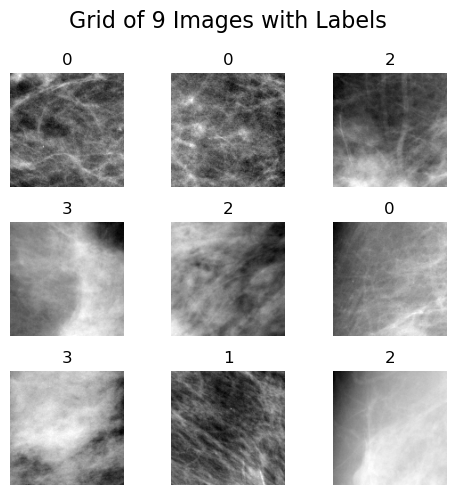

In [36]:
from src.utils.visualization import sample_images

sample_images(dataloader)